<div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone Project Modeling: Funk SVD  </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

<br>
<br>
<br>


### Camilo Salazar <br> BrainStation <br> November 10, 2023

## Introduction

In this notebook, we will dive into the core of our book recommender project. Our primary objective is to create an intelligent recommendation engine that effortlessly connects readers with books that align with their interests. Achieving this goal requires meticulous fine-tuning of the Funk Singular Value Decomposition (Funk SVD) model, a pivotal component of our recommendation system. Our approach to this fine-tuning process is comprehensive and rigorous. We start by selecting a subsample of the data, consisting of approximately 3.33% of the entire dataset. This initial step allows for rapid experimentation and optimization of our model's hyperparameters. The focus here is on efficiency and speed. To ensure our model's robustness and reliability, we implement a five-fold cross-validation strategy on the subsampled data. This technique helps us narrow the range of hyperparameter choices, making it a pivotal part of our fine-tuning process. Following cross-validation, we delve into hyperparameter optimization through grid search. This iterative process aims to identify the best hyperparameter combination while preventing overfitting. This stage is crucial in fine-tuning the model for optimal performance.

With our model well-tuned on the subsampled data, we transition to a more comprehensive testing phase involving 80% of the dataset. This step allows us to evaluate our model's effectiveness across a broader spectrum of users and books. The final leg of our journey focuses on additional hyperparameter tuning tailored to the larger dataset. Our ultimate aim is to achieve the highest level of recommendation accuracy for our book recommender system. By the end of this notebook, you will have a finely tuned Funk SVD model ready to deliver top-notch book recommendations to our readers. Let's embark on this journey of fine-tuning and optimization together.

In [1]:
# imports usefull libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import random

# import Supriside to run model 
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#loading all dataframes
book_df = pd.read_csv('data/books.csv')
tags_df = pd.read_csv('data/tags.csv')
book_tags_df = pd.read_csv('data/book_tags.csv')
ratings_df = pd.read_csv('data/ratings.csv')

---
## Table of Content

- [Splitting Data & Baseline Model](#part-1)
- [Small Data Hyper Parameter Tuning](#part-2)
- [Large Data Hyper Parameter Tuning](#part-3)
- [Testing Final Model](#part-4)

---
## Splitting Data & Baseline Model <a class="anchor" id="part-1"></a>

To begin, we need to set up a reader that will allow us to read the rating data, specifying our rating scale from 1 to 5. We can then load the data using the functions provided by the surprise module. However, an issue arises when attempting to use the train_test_split function and cross-validation functions, as they are not compatible with eachother. To resolve this, we need to conduct the data split manually. This involves loading the raw data, shuffling it randomly, splitting it into appropriate segments, and finally incorporating it back into our dataset as the new raw data.

In [4]:
# set reader of the rating
reader = Reader(rating_scale=(1, 5))

In [419]:
#load the dataset
split_data = Dataset.load_from_df(ratings_df, reader)

# randomly shuffle the data for spliting
raw_ratings = split_data.raw_ratings
random.seed(36)
random.shuffle(raw_ratings)

# split up the data to only 1/30 for inital testing
threshold = int(29/30 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

# set the small data set as the data
split_data.raw_ratings = B_raw_ratings
trainsplit = split_data.build_full_trainset()

# run model with the split data
model = FunkSVD()
model.fit(trainsplit)
# check the number of missing users and missing books in the split data
print(f'{model.pu.shape[0]-53424} number of user are missing from the split')
print(f'{model.qi.shape[0]-10000} books are missing from the split data')

-1794 number of user are missing from the split
-75 books are missing from the split data


It looks like our split was executed correctly, and now we have a smaller portion of the data, comprising approximately 3.33% of the original size. It's important to note that with this split, we have lost 75 books and 1794 users from the dataset.

In [426]:
# doing an intial croos validation to check the data was split correctly
model = FunkSVD()

csm1 = cross_validate(model,split_data, measures=["RMSE", "MAE", "FCP"])

print(f"Mean RMSE = {csm1['test_rmse'].mean()}")
print(f"Mean MAE  = {csm1['test_mae'].mean()}")
print(f"Mean FCP  = {csm1['test_fcp'].mean()}")

Mean RMSE = 0.9439413858343884
Mean MAE  = 0.7549063447127466
Mean FCP  = 0.5167996073556248


---
## Small Data Hyper Parameter Tuning <a class="anchor" id="part-2"></a>

Before beginning our hyperparameter tuning, the first step involves defining several functions designed to streamline and expedite the process. These functions play a pivotal role in conducting five-fold cross-validation across a range of hyperparameters. They generate a comprehensive dataframe that captures the hyperparameters used and their corresponding error measurements, while also enabling us to visualize the results through plots encompassing all three performance metrics.

In [406]:
def cv_funksvd(data, nf = 100, ne = 20, lr = 0.005, bsd = True, cvs = 5): 
    '''
    Performs cross-validation for a Funk SVD model using different hyperparameters.

    Parameters
    ----------
    data: surprise.Dataset
        The dataset for training and testing the model.
    nf: int, optional
        The number of latent factors for the model. Default is 100.
    ne: int, optional
        The number of epochs for training. Default is 20.
    lr: float, optional
        The learning rate for training. Default is 0.005.
    bsd: bool, optional
        Whether to use bias terms. Default is True.
    cvs: int, optional
        The number of cross-validation folds. Default is 5.

    Returns
    -------
    meanframe: pandas.DataFrame
        A DataFrame containing the specified hyperparameters and the average RMSE, MAE, and FCP from the croos validation.
    '''
    
    # Create a FunkSVD model with specified hyperparameters
    model = FunkSVD(n_factors=nf,
                            n_epochs=ne, 
                            lr_all= lr,
                            biased= bsd,
                            random_state = 42)
    # Perform cross-validation on the model with specified metrics and number of folds
    cross_va = cross_validate(model, data, measures=["RMSE", "MAE", "FCP"],
                              cv = cvs, n_jobs = 5)
   # Calculate the mean RMSE, MAE, and FCP scores from the cross-validation results                           
    RMSE = cross_va['test_rmse'].mean()
    MAE = cross_va['test_mae'].mean()
    FCP = cross_va['test_fcp'].mean()
    
    # Create a DataFrame to store the hyperparameters and corresponding error measurements
    meanframe = pd.DataFrame({'NFactors':[nf],
                             'Epochs': [ne],
                             'Learning Rate': [lr],
                              'Biase': [bsd],
                             'RMES': [np.round(RMSE,4)],
                            'MAE': [np.round(MAE,4)],
                            'FCP' : [np.round(FCP,4)]})
    return meanframe

def mul_test(data, lsparm, parnm):
    '''
    Performs multiple cross-validation tests for different hyperparameters and compiles the results.

    Parameters
    ----------
    data: surprise.Dataset
        The dataset for training and testing the model.
    lsparm: list
        A list of hyperparameter values to test.
    parnm: str
        The name of the hyperparameter to change (e.g., 'NFactors', 'Epochs', 'Learning Rate').

    Returns
    -------
    mul_df: pandas.DataFrame
        A DataFrame containing the results of cross-validation tests for different hyperparameters.
    '''
    
    # Define an index dictionary to map parameter names to their positions in the list
    parm_ind = {'NFactors': 0, 'Epochs': 1, 'Learning Rate' : 2}
    
    # Check if the provided parameter name is valid
    if parnm not in parm_ind:
        raise ValueError("Invalid parameter_to_change")
    
    # Create an empty DataFrame to store results
    mul_df = pd.DataFrame([])
    
    # Iterate through the provided list of parameter values
    for par in lsparm:
        # Create a list of default parameters
        parameters = [100,20,0.005]
        
        # Replace the parameter value at the specified index with the new value
        parameters[parm_ind[parnm]] = par
        
        # Run the cv_funksvd function with the updated parameters and concatenate the results
        mul_df = pd.concat([mul_df,cv_funksvd(data, *parameters)])
        
    # Reset the index of the DataFrame and remove the old index column
    mul_df = mul_df.reset_index().drop(columns = 'index')
    return mul_df

def error_plts(df,x):
    '''
    Plots the error metrics (RMSE, MAE, FCP) for different hyperparameter values.

    Parameters
    ----------
    df: pandas.DataFrame
        A DataFrame containing the hyperparameter values and corresponding error metrics.
    x: str
        The hyperparameter name to be plotted on the x-axis.
    '''
        
    # Sort the DataFrame based on the specified x-axis parameter
    df = df.sort_values(x)
    
    # Create a subplot with three axes for RMSE, MAE, and FCP
    plt.subplots(1,3,figsize = (18,6),facecolor = "#fffbf0")
    
    # Plot RMES
    ax = plt.subplot(1,3,1)
    ax.set_facecolor("#fffbf0")
    plt.plot(df[x],df['RMES'],'-o',
             label = f'MIN RMES = {np.round(df["RMES"].min(),4)},\n{x} = {df[df["RMES"] == df["RMES"].min()][x].iloc[0]}',
             color = '#26a69a')
    plt.legend()
    plt.title('RMES')
    plt.xticks(df[x],df[x])
    plt.xlabel(f'{x}')
    plt.grid()
    
    # Plot MAE
    ax = plt.subplot(1,3,2)
    ax.set_facecolor("#fffbf0")
    plt.plot(df[x],df['MAE'], '-o',
             label = f'MIN MAE = {np.round(df["MAE"].min(),4)},\n{x} = {df[df["MAE"] == df["MAE"].min()][x].iloc[0]}',
             color = '#26a69a')
    plt.legend()
    plt.title('MAE')
    plt.xticks(df[x],df[x])
    plt.xlabel(f'{x}')
    plt.grid()
    
    # Plot FCP
    ax = plt.subplot(1,3,3)
    ax.set_facecolor("#fffbf0")
    plt.plot(df[x],df['FCP'], '-o',
             label = f'MAX FCP = {np.round(df["FCP"].max(),4)},\n{x} = {df[df["FCP"] == df["FCP"].max()][x].iloc[0]}',
             color = '#26a69a')
    plt.legend()
    plt.xticks(df[x],df[x])
    plt.title('FCP')
    plt.xlabel(f'{x}')
    plt.grid()
    
    # Add a common title for all three plots
    plt.suptitle(f'{x} Accuracy Metrics Plots', fontsize = 18)
    
    # Ensure proper layout and display the plots
    plt.tight_layout()
    plt.show()

In [56]:
# testig function 
cv_funksvd(split_data,nf = 10,bsd = False)

,NFactors,Epochs,Learning Rate,Biase,RMES,MAE,FCP
0,10,20,0.005,False,2.8371,2.5977,0.471


Now that we have all the necessary functions set up, we can proceed with our fine-tuning process, starting by focusing on the `n_factors` hyperparameter. This hyperparameter represents the number of latent factors we want to generate for each user and book in our dataset. In this step, our goal is to evaluate `n_factors` over a wide range to understand its behavior and identify a range of values that show promise. This initial evaluation will provide valuable insights, allowing us to narrow down the range for more in-depth analysis in subsequent steps. By systematically exploring the n_factors hyperparameter, we can make more informed decisions about its optimal value for our FunkSVD model.

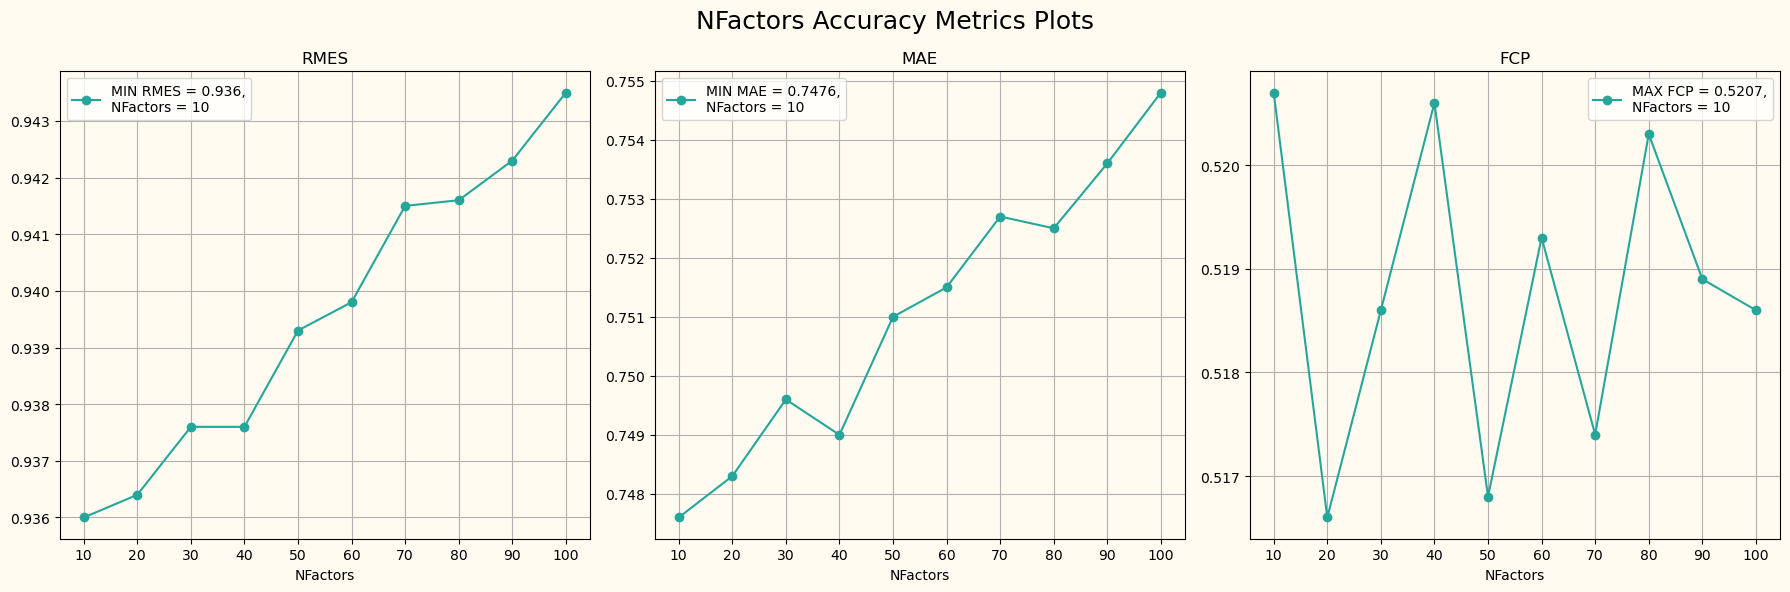

In [57]:
# measuring and visualising errors for a range of n_factors
nfacts_cv1 = mul_test(split_data, [10,20,30,40,50,60,70,80,90,100], 'NFactors')
error_plts(nfacts_cv1,'NFactors')

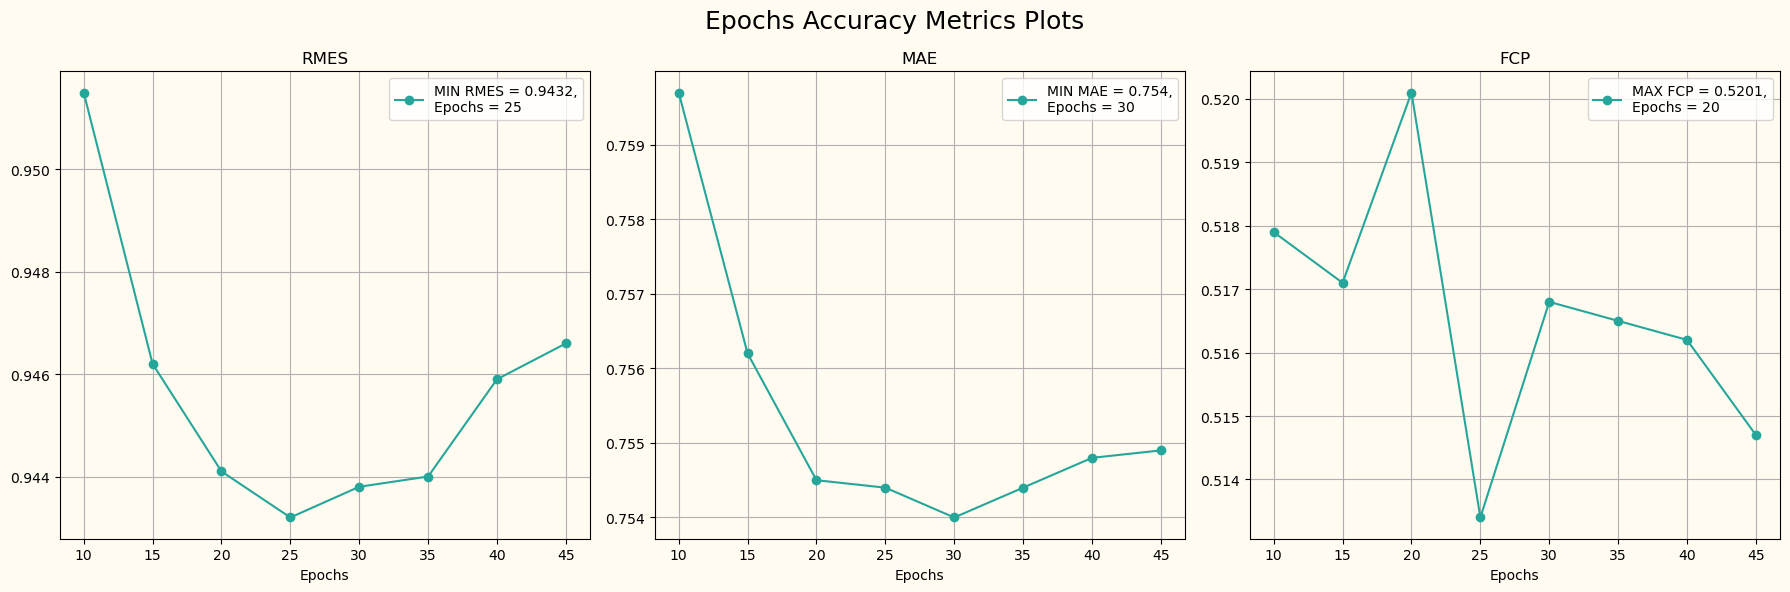

In [58]:
# measuring and valuating epocs for a range of values
epoc_cv = mul_test(split_data, [10,15,20,25,30,35,40,45], 'Epochs')
error_plts(epoc_cv,'Epochs')

In [64]:
# setting up a gridsearch to search over the narrow down values
model = FunkSVD()

param_grid = {"n_factors": [5,10,15,40],"n_epochs": [20,25,30,35], "lr_all": [0.0005,0.005,0.05]}
gs1 = GridSearchCV(FunkSVD, param_grid, measures=["rmse", "mae", "fcp"], cv=5, n_jobs = 5)

gs1.fit(split_data)


print('RMES Best Score:', np.round(gs1.best_score["rmse"],4) , gs1.best_params["rmse"])
print('MAE  Best Score:', np.round(gs1.best_score["mae"],4),gs1.best_params["mae"])
print('FCP  Best Score:', np.round(gs1.best_score["fcp"],4),gs1.best_params["fcp"])

gr1 = pd.DataFrame(gs1.cv_results)[['param_n_factors','param_n_epochs','param_lr_all','mean_test_rmse','mean_test_mae','mean_test_fcp']]

RMES Best Score: 0.9323 {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005}
MAE  Best Score: 0.7439 {'n_factors': 5, 'n_epochs': 35, 'lr_all': 0.005}
FCP  Best Score: 0.5222 {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005}


In [66]:
gr1.iloc[[7,10,13]]

,param_n_factors,param_n_epochs,param_lr_all,mean_test_rmse,mean_test_mae,mean_test_fcp
7,5,30,0.005,0.932275,0.744370,0.521382
10,5,35,0.005,0.932575,0.743866,0.520488
13,10,20,0.005,0.935646,0.747863,0.522213


In [67]:
# second gridserch over a more refined gridsearch
model = FunkSVD()

param_grid = {"n_factors": [5,10],"n_epochs": [20,30,35], "lr_all": [0.005,0.0025,0.0075,0.001,0.01]}
gs2 = GridSearchCV(FunkSVD, param_grid, measures=["rmse", "mae", "fcp"], cv=5, n_jobs = 5)

gs2.fit(split_data)

print('RMES Best Score:', np.round(gs2.best_score["rmse"],4) , gs2.best_params["rmse"])
print('MAE  Best Score:', np.round(gs2.best_score["mae"],4),gs2.best_params["mae"])
print('FCP  Best Score:', np.round(gs2.best_score["fcp"],4),gs2.best_params["fcp"])

gr2 = pd.DataFrame(gs2.cv_results)[['param_n_factors','param_n_epochs','param_lr_all','mean_test_rmse','mean_test_mae','mean_test_fcp']]

RMES Best Score: 0.9322 {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.0075}
MAE  Best Score: 0.7436 {'n_factors': 5, 'n_epochs': 35, 'lr_all': 0.005}
FCP  Best Score: 0.521 {'n_factors': 10, 'n_epochs': 35, 'lr_all': 0.0025}


In [71]:
gr2.iloc[[2,10,26]]

,param_n_factors,param_n_epochs,param_lr_all,mean_test_rmse,mean_test_mae,mean_test_fcp
2,5,20,0.0075,0.932198,0.744099,0.519983
10,5,35,0.0050,0.932446,0.743575,0.520430
26,10,35,0.0025,0.937124,0.748655,0.520969


---
## Large Data Hyper Parameter Tuning <a class="anchor" id="part-3"></a>

In [39]:
# split up the data to 80% for inital testing
threshold = int(0.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

# set the small data set as the data
split_data.raw_ratings = A_raw_ratings
trainsplit = split_data.build_full_trainset()

# run model with the split data
model = FunkSVD()
model.fit(trainsplit)
# check the number of missing users and missing books in the split data
print(f'{model.pu.shape[0]-53424} number of user are missing from the split')
print(f'{model.qi.shape[0]-10000} books are missing from the split data')

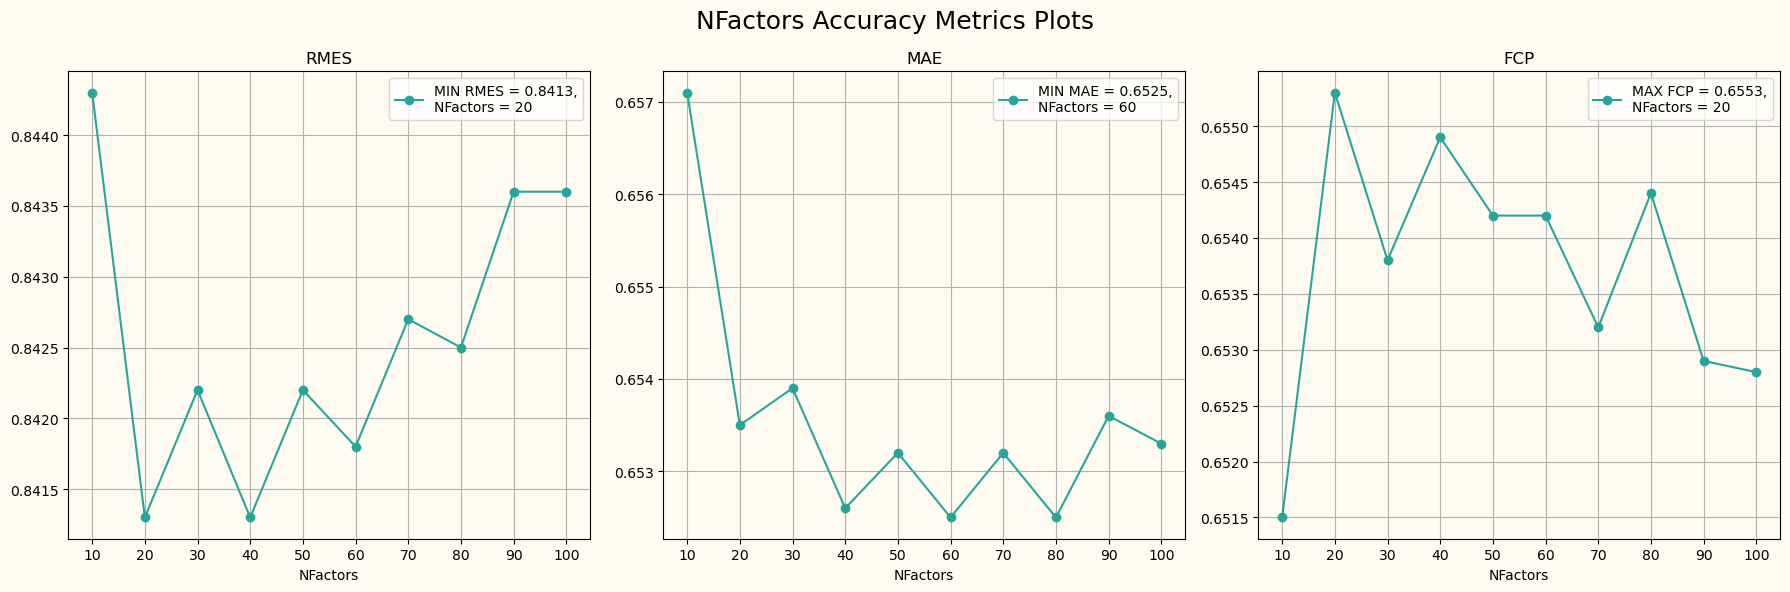

In [26]:
nfacts_cv1 = mul_test(split_data, [10,20,30,40,50,60,70,80,90,100], 'NFactors')
error_plts(nfacts_cv1,'NFactors')

In [79]:
model = FunkSVD()

param_grid = {"n_factors": [20,40,60,80],"n_epochs": [20,35], "lr_all": [0.0075,0.005,0.0025]}
gs3 = GridSearchCV(FunkSVD, param_grid, measures=["rmse", "mae", "fcp"], cv=5, n_jobs = 5)

gs3.fit(split_data)


print('RMES Best Score:', np.round(gs3.best_score["rmse"],4) , gs3.best_params["rmse"])
print('MAE  Best Score:', np.round(gs3.best_score["mae"],4),gs3.best_params["mae"])
print('FCP  Best Score:', np.round(gs3.best_score["fcp"],4),gs3.best_params["fcp"])

gr3 = pd.DataFrame(gs3.cv_results)[['param_n_factors','param_n_epochs','param_lr_all','mean_test_rmse','mean_test_mae','mean_test_fcp']]

RMES Best Score: 0.8404 {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.0075}
MAE  Best Score: 0.6483 {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.0075}
FCP  Best Score: 0.6583 {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.0075}


In [80]:
gr3.iloc[[0,1]]

,param_n_factors,param_n_epochs,param_lr_all,mean_test_rmse,mean_test_mae,mean_test_fcp
0,20,20,0.0075,0.840395,0.648292,0.658299
1,20,20,0.0050,0.842217,0.654428,0.653575


In [81]:
model = FunkSVD()

param_grid = {"n_factors": [20],"n_epochs": [20], "lr_all": [0.0075], 'biased': [True, False]}
gs4 = GridSearchCV(FunkSVD, param_grid, measures=["rmse", "mae", "fcp"], cv=5, n_jobs = 5)

gs4.fit(split_data)


print('RMES Best Score:', np.round(gs4.best_score["rmse"],4) , gs4.best_params["rmse"])
print('MAE  Best Score:', np.round(gs4.best_score["mae"],4),gs4.best_params["mae"])
print('FCP  Best Score:', np.round(gs4.best_score["fcp"],4),gs4.best_params["fcp"])

gr4 = pd.DataFrame(gs4.cv_results)[['param_biased','mean_test_rmse','mean_test_mae','mean_test_fcp']]

RMES Best Score: 0.8394 {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.0075, 'biased': False}
MAE  Best Score: 0.6488 {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.0075, 'biased': False}
FCP  Best Score: 0.6646 {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.0075, 'biased': False}


---
## Testing Final Model <a class="anchor" id="part-4"></a>

In [342]:
my_data = Dataset.load_from_df(ratings_df, reader)
trainset, testset = train_test_split(my_data, test_size=.20, random_state = 42)

In [343]:
final_model = FunkSVD( n_factors = 20,
                 n_epochs = 20,
                 lr_all = 0.0075,
                 biased = False)

final_model.fit(trainset)

In [344]:
book_latent = final_model.qi
book_latent

array([[-0.31863319,  0.17730284, -0.34003181, ...,  0.9798573 ,
         0.08319699,  0.48123695],
       [ 0.06280942, -0.45405571,  0.92644267, ...,  0.7467845 ,
        -0.57431348,  0.25174768],
       [ 0.38535889,  0.28836753, -0.28667389, ...,  0.44101326,
        -0.10877625,  0.63294599],
       ...,
       [-0.03601772,  0.01920702,  0.2568196 , ...,  0.70238468,
        -0.19204993,  0.12526347],
       [-0.05166961, -0.35927761,  0.06845388, ...,  0.51977198,
        -0.21864223,  0.08160725],
       [ 0.00820914, -0.01631162,  0.42339699, ...,  1.12591965,
        -0.39529197,  0.09779532]])

In [371]:
book_simind = pd.DataFrame(list(trainset._raw2inner_id_items.items()
),columns=['book_id', 'Vindex']).set_index('book_id', drop=True)
book_simind

,Vindex
book_id,
2757,0
134,1
1463,2
71,3
3339,4
...,...
7636,9995
9080,9996
9980,9997


In [346]:
def id_bookinfo(b_id):
    '''
    Retrieves book information based on a given book ID.

    Parameters
    ----------
    b_id: int
        The book ID (an integer) for the book to retrieve information about. Should be between 1 and 10,000.

    Returns
    -------
    result: pandas.DataFrame
        A DataFrame containing information about the book, including title, authors, and original publication year.
    '''
    # checks that the book id is and int and valid
    if (not isinstance(b_id, int)) or ((b_id < 1) or (b_id > 10000)):
        raise ValueError("Invalid Book Id Pick an Integer between 1-10000")
    
    result = book_df[book_df['book_id'] == b_id][['title', 'authors', 'original_publication_year']]
    return result

def title_to_id(b_title):
    '''
    Retrieves the book ID based on a given book title.

    Parameters
    ----------
    b_title: str
        The title of the book to find the corresponding book ID for.

    Returns
    -------
    result: int
        The book ID associated with the given title.
    '''
    
    result = book_df[book_df['title'] == b_title]['book_id']
    return result.values[0]

def vin_to_id(vin):
    '''
    Retrieves the book ID based on a given Vindex (index in a similarity matrix).

    Parameters
    ----------
    vin: int
        The Vindex value representing a book's index in a similarity matrix.

    Returns
    -------
    result: int
        The book ID associated with the given Vindex.
    '''
    result = book_simind[book_simind['Vindex'] == vin].index[0]
    return result

def id_to_vin(inb):
        '''
    Retrieves the Vindex (index in a similarity matrix) based on a given book ID.

    Parameters
    ----------
    inb: int
        The book ID for which the Vindex is needed.

    Returns
    -------
    result: int
    The Vindex associated with the given book ID
        '''
        
    result = book_simind.loc[inb][0]
    return result

def title_to_vin(b_title):
       '''
    Retrieves the Vindex (index in a similarity matrix) based on a given book title.

    Parameters
    ----------
    b_title: str
        The title of the book for which the Vindex is needed.

    Returns
    -------
    result: int
        The Vindex associated with the given book title.
    '''
        
    result = id_to_vin(title_to_id(b_title))
    return result
    
    

In [407]:
def recomender(b_title, book_similarities, bi):
    '''
    Recommends books similar to a given book title based on book similarities.

    Parameters
    ----------
    b_title: str
        The title of the book for which you want book recommendations.
    book_similarities: np.ndarray
        A 2D numpy array containing book similarities where each row represents a book.
    bi: pd.DataFrame
        A DataFrame containing book indices.

    Returns
    -------
    results: pd.DataFrame
        A DataFrame containing book recommendations and their similarities to the input book.
    '''
    # Copy book_similarities to a local variable for manipulation
    sim_arr = book_similarities
    # Create a copy of the book indices DataFrame
    botoind = bi.copy()
    # Get the Vindex (index in similarity matrix) of the input book title
    vin = title_to_vin(b_title)
    # Extract similarity data for the input book
    data = sim_arr[vin]
    # Add the Similarities column to the book indices DataFrame
    botoind['Similarities'] = data
    # Sort books by similarity in descending order
    botoind.sort_values('Similarities', ascending=False, inplace=True)
    # Remove the input book from the recommendations
    botoind = botoind.drop(vin_to_id(vin))
    # Get the top 10 book indices
    top10ind = botoind.head(10).index
    results = pd.DataFrame([])
    # Retrieve book information for the top 10 recommended books
    for b_id in top10ind:
        res = id_bookinfo(b_id)
        results = pd.concat([results, res])
    # Add the Similarities column to the recommendations DataFrame
    results['Similarities'] = botoind.head(10)['Similarities'].values
    return results

    
    

In [348]:
from sklearn.metrics.pairwise import cosine_similarity 
book_similarities = cosine_similarity(book_latent, dense_output=False)

In [394]:
recomender("An Astronaut's Guide to Life on Earth",book_similarities,book_simind)

,title,authors,original_publication_year,Similarities
6148,The Willpower Instinct: How Self-Control Works...,Kelly McGonigal,2011.0,0.972695
6671,"Path of the Assassin (Scot Harvath, #2)",Brad Thor,2003.0,0.970077
6925,"Foxglove Summer (Peter Grant, #5)",Ben Aaronovitch,2014.0,0.961847
5447,Family Matters,Rohinton Mistry,2001.0,0.961368
5795,The Speed of Trust: The One Thing that Changes...,Stephen M.R. Covey,2006.0,0.960694
6881,The Shallows: What the Internet is Doing to Ou...,Nicholas Carr,2010.0,0.959134
8756,The Complete Works of H.P. Lovecraft,H.P. Lovecraft,1978.0,0.958466
9667,"The Broken Kingdoms (Inheritance, #2)",N.K. Jemisin,2010.0,0.956996
5124,Stories of Your Life and Others,Ted Chiang,2002.0,0.956867
2319,"Chronicles, Vol. 1",Bob Dylan,2004.0,0.956429


In [418]:
recomender("5 Very Good Reasons to Punch a Dolphin in the Mouth and Other Useful Guides",book_similarities,book_simind)

,title,authors,original_publication_year,Similarities
5807,Hey Nostradamus!,Douglas Coupland,2003.0,0.980940
8550,"The Queen's Poisoner (Kingfountain, #1)",Jeff Wheeler,2016.0,0.977349
7944,"Ender's Game, Volume 2: Command School","Christopher Yost, Pasqual Ferry, Orson Scott Card",2010.0,0.976723
9847,"A Civil Campaign (Vorkosigan Saga, #12)",Lois McMaster Bujold,1999.0,0.976618
9568,The Hate U Give,Angie Thomas,2017.0,0.975862
9870,"Black Cherry Blues (Dave Robicheaux, #3)",James Lee Burke,1989.0,0.975705
7907,"Extreme Prey (Lucas Davenport, #26)",John Sandford,2016.0,0.975112
8543,The Invisible Gorilla: And Other Ways Our Intu...,"Christopher Chabris, Daniel Simons",2010.0,0.974778
9428,"Rogue Squadron (Star Wars: X-Wing, #1)",Michael A. Stackpole,1996.0,0.973908
6803,Drift: The Unmooring of American Military Power,Rachel Maddow,2012.0,0.973822


array(['5 Very Good Reasons to Punch a Dolphin in the Mouth and Other Useful Guides'],
      dtype=object)